## INTRO   

### 주제
- 앱 이용자 별 향후 이용 건수 예측
- 이용자 별 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용
  
### 모델 개발 요건
- 이용자 별 결제 이력을 바탕으로 한 향후 한 달간 이용 건수 예측
  
### Data 정의
- Input: Tabular 데이터(2020.01.01 ~ 2020.12-31)
- Output: Regression (향후 이용 건수 예측)  

### Task 정의
- Regression, 유저 별 한 달 후 이용 건수 예측
  
### Metric 정의
- MSE, MAE
  
### 데이터 수집
- 유저 가입 정보: id(USER_ID) , 가입일(JOIN_DATE) 
- 소비 행동 정보: 상품id(GOODS_TYPE), 점포 주소(STORE_ID), 결제일(DATE), 결제건수(COUNT) 
- 외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터  

## Data Load   
### 모두 컴퍼니 

In [69]:
import pandas as pd 
import numpy as np 
import missingno as msno
from datetime import datetime, timezone, timedelta
import pytz
from tqdm.notebook import tqdm as tqdm

import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False  

# API 크롤링 라이브러리 
from urllib.parse import urlencode, quote_plus
from urllib.request import Request, urlopen
from xml.etree import ElementTree 
from urllib.error import HTTPError
import requests

from statsmodels.tsa.seasonal import seasonal_decompose 


pd.options.display.max_rows=100

In [2]:
data = pd.read_csv('../project_modu/data_modu.csv')
data.drop(columns=['Unnamed: 0', 'Year'], inplace=True)
data.weekofday=data.weekofday.astype(int)

In [3]:
print(f'데이터 사이즈 : {data.shape}')

데이터 사이즈 : (879271, 11)


In [4]:
# msno.matrix(data)  #missing values (X) 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
 8   Month       879271 non-null  int64 
 9   Day         879271 non-null  int64 
 10  weekofday   879271 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 73.8+ MB


In [184]:
data['DATE']=pd.to_datetime(data['DATE'])
data['JOIN_DATE']=pd.to_datetime(data['JOIN_DATE'])

# 결제날짜 : 연도, 월, 일 컬럼 생성 
# data['Year'] = data.DATE.dt.year
# data['Month'] = data.DATE.dt.month
# data['Day'] = data.DATE.dt.day

# 가입날짜 : 연도, 월, 일 컬럼  -> 필요할까? 
# data['JOIN_Year'] = data.JOIN_DATE.dt.year
# data['JOIN_Month'] = data.JOIN_DATE.dt.month
# data['JOIN_Day'] = data.JOIN_DATE.dt.day

# 결제 요일 
# KST = pytz.timezone('Asia/Seoul')
# for idx, (m, d) in enumerate(zip(data.Month, data.Day)):
#     mydate = datetime(2020, m,d)
#     mydate_kst = KST.localize(mydate)
#     data.at[idx, 'weekofday'] = mydate_kst.weekday()

In [7]:
test=data[data['DATE']>='2020-10-01']
train = data[data['DATE']<'2020-10-01']

In [8]:
display(train.head(3))
display(test.head(3))

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,Month,Day,weekofday
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1,1,2
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1,1,2
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1,1,2


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,Month,Day,weekofday
623579,15521,2014-09-12,AA,182320,A,2020-10-01,1,JRR,10,1,3
623580,17651,2014-09-19,BB,82434,D,2020-10-01,1,J,10,1,3
623581,26388,2014-10-25,BB,182320,A,2020-10-01,1,JRR,10,1,3


### 날씨 - API 크롤링 

In [9]:
# 공유된 데이터 확인
# weather = pd.read_csv('../project_modu/서울시_기상데이터.csv', encoding='CP949')

# 일자별 날씨로 크롤링 하기로 함 
# ------------------------ 크롤링
# params = '?'+ 'ServiceKey=' + service_key + '&' + \
#     urlencode({ quote_plus('ServiceKey') : '서비스키', 
#                 quote_plus('dataType') : 'XML',
#                 quote_plus('pageNo') : '1', 
#                 quote_plus('numOfRows') : '365', 
#                 quote_plus('dataCd') : 'ASOS',
#                 quote_plus('dateCd') : 'DAY', 
#                 quote_plus('startDt') : '20200101',  
#                 quote_plus('endDt') : '20201231', 
#                 quote_plus('stnIds') : '108' })

               
# df = pd.DataFrame()
    
    
# request = Request(url + params)
# request.get_method = lambda: 'GET'

# try:
#     response_body = urlopen(request).read()
# except HTTPError as e:
#     print(e)
# except URLError as e:
#     print('The server coult not be found')
# else:
#     print('성공')


# root= ElementTree.fromstring(response_body)

# for item in root.iter('item'):
#     item_dict = {}
# #     지점, 일시, 기온, 강수량, 풍속, 습도, 일조시간, 적설량, 지면온도, 지중온도
#     item_dict['일시'] = item.find('tm').text
#     item_dict['지점'] = item.find('stnId').text
#     item_dict['평균기온'] = item.find('avgTa').text
#     item_dict['일강수량'] = item.find('sumRn').text
#     item_dict['평균풍속'] = item.find('avgWs').text
#     item_dict['평균상대습도'] = item.find('minRhmHrmt').text
#     item_dict['가조시간'] = item.find('ssDur').text
#     item_dict['일적설량'] = item.find('ddMefs').text
#     item_dict['3시간 적설량'] = item.find('sumDpthFhsc').text
#     item_dict['지면온도'] = item.find('avgTs').text
#     item_dict['평균10cm 지중온도'] = item.find('avgCm10Te').text
#     item_dict['평균5cm 지중온도'] = item.find('avgCm5Te').text
#     item_dict['평균20cm 지중온도'] = item.find('avgCm20Te').text
    
#     df=df.append(item_dict, ignore_index=True)

# df.to_csv(path_or_buf =r'weather_day.csv', encoding='euc-kr')

# print(df)

# weather_day = pd.read_csv('./weather_day.csv', encoding='CP949')
# weather_day=weather_day[['지점','일시', '평균기온', '일강수량', '평균풍속','평균상대습도','가조시간','일적설량','3시간 적설량', '평균5cm 지중온도', '평균10cm 지중온도']]


# ------------------------ csv 
# weather_day.to_csv('../project_modu/weather_day.csv')

In [10]:
weather_day = pd.read_csv('../project_modu/weather_day.csv')
weather_day.drop(columns=['Unnamed: 0'], inplace=True)

In [11]:
weather_day

,지점,일시,평균기온,일강수량,평균풍속,평균상대습도,가조시간,일적설량,3시간 적설량,평균5cm 지중온도,평균10cm 지중온도
0,108,2020-01-01,-2.2,0.1,0.6,2,9.6,0.0,0.0,-0.4,0.5
1,108,2020-01-02,1.0,NaN,1.2,1212,9.6,NaN,NaN,0.0,0.7
2,108,2020-01-03,-0.1,NaN,1.7,1430,9.7,NaN,NaN,0.3,1.0
3,108,2020-01-04,1.2,NaN,1.9,1457,9.7,NaN,NaN,0.4,1.1
4,108,2020-01-05,1.3,NaN,1.1,1518,9.7,NaN,NaN,0.2,1.0
...,...,...,...,...,...,...,...,...,...,...,...
360,108,2020-12-26,2.2,NaN,1.8,1455,9.6,NaN,NaN,0.5,-0.1
361,108,2020-12-27,5.8,0.0,1.8,1457,9.6,NaN,NaN,0.7,0.2
362,108,2020-12-28,6.7,1.3,1.4,1618,9.6,NaN,NaN,2.6,1.6
363,108,2020-12-29,0.1,0.2,2.9,2040,9.6,NaN,NaN,2.1,1.6


### 교통량 정보   
- 지점명 = 위치정보  .. 해당 위치에 얼마나 많은 교통량이 있었는가의 정보  
- 시간대별 유입과 유출 모두 있으므로 일자별 계산을 어떻게 해야할 것인지 정해야함.  
예를 들면 +유입-유출 이렇게 계산을 할 것인지.. 

In [12]:
traffic = pd.read_excel('../project_modu/2020교통량통합.xlsx', header=None)
traffic = pd.DataFrame(traffic.values)

In [13]:
traffic.columns = traffic.iloc[0]
traffic=traffic.iloc[1:]

In [14]:
# traffic.head(3)

### Data Merging 
  
on = Date,  원데이터셋 + 일자별 평균기온, 강수량, 적설량 ... + 일자별 교통량? 

In [258]:
weather_day.info()
# weather_day['일강수량'].fillna(0, inplace=True)
# weather_day['일적설량'].fillna(0, inplace=True)
# weather_day['3시간 적설량'].fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   지점           365 non-null    int64         
 1   일시           365 non-null    datetime64[ns]
 2   평균기온         365 non-null    float64       
 3   일강수량         365 non-null    float64       
 4   평균풍속         365 non-null    float64       
 5   평균상대습도       365 non-null    int64         
 6   가조시간         365 non-null    float64       
 7   일적설량         365 non-null    float64       
 8   3시간 적설량      365 non-null    float64       
 9   평균5cm 지중온도   362 non-null    float64       
 10  평균10cm 지중온도  362 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 31.5 KB


In [259]:
weather_day['일시']=pd.to_datetime(weather_day['일시'])
data_all=pd.merge(data, weather_day, left_on='DATE', right_on='일시')

In [289]:
data_all.columns=['USER_ID', 'JOIN_DATE', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 'DATE',
       'COUNT', 'AD1', 'Month', 'Day', 'weekofday', 'quartile',
       'weekofday_bins', 'JOIN_DAYS', 'point', 'weather_date', 'avgTemp', 'rainfall_Day', 'avgWind',
       'avgHumid', 'du_sunshine', 'snow_day', 'snow_3h', 'avg5cm', 'avg10cm']

In [290]:
data_all

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,Month,Day,...,weather_date,avgTemp,rainfall_Day,avgWind,avgHumid,du_sunshine,snow_day,snow_3h,avg5cm,avg10cm
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1,1,...,2020-01-01,-2.2,0.1,0.6,2,9.6,0.0,0.0,-0.4,0.5
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1,1,...,2020-01-01,-2.2,0.1,0.6,2,9.6,0.0,0.0,-0.4,0.5
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1,1,...,2020-01-01,-2.2,0.1,0.6,2,9.6,0.0,0.0,-0.4,0.5
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1,1,...,2020-01-01,-2.2,0.1,0.6,2,9.6,0.0,0.0,-0.4,0.5
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,1,1,...,2020-01-01,-2.2,0.1,0.6,2,9.6,0.0,0.0,-0.4,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876551,1829449,2020-12-30,BB,28014,B,2020-12-30,1,J,12,30,...,2020-12-30,-10.9,0.0,4.1,1525,9.6,0.0,0.0,0.6,0.5
876552,1829480,2020-12-30,AA,105033,B,2020-12-30,1,SC,12,30,...,2020-12-30,-10.9,0.0,4.1,1525,9.6,0.0,0.0,0.6,0.5
876553,1829513,2020-12-30,BB,219936,B,2020-12-30,1,YD,12,30,...,2020-12-30,-10.9,0.0,4.1,1525,9.6,0.0,0.0,0.6,0.5
876554,1829615,2020-12-30,BB,158176,B,2020-12-30,1,SC,12,30,...,2020-12-30,-10.9,0.0,4.1,1525,9.6,0.0,0.0,0.6,0.5


## Data Understanding 

In [15]:
data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,Month,Day,weekofday
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1,1,2
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1,1,2
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1,1,2
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1,1,2
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,1,1,2


### 중복 ID가 있는가? 

In [16]:
print(f'기록된 유저ID 갯수 : {len(data["USER_ID"])}')
print(f'중복값을 제거한 고유 유저ID 갯수 :{data["USER_ID"].nunique()}')

기록된 유저ID 갯수 : 879271
중복값을 제거한 고유 유저ID 갯수 :165425


In [17]:
print(f'test 데이터 셋에만 있는 고유 ID : {len(set(test.USER_ID)-set(train.USER_ID))}')
print(f'train 데이터 셋에만 있는 고유 ID : {len(set(train.USER_ID)-set(test.USER_ID))}')
print(f'train & test 데이터 셋에 모두 있는 고유 ID : {len(set(train.USER_ID)&set(test.USER_ID))}')

test 데이터 셋에만 있는 고유 ID : 35165
train 데이터 셋에만 있는 고유 ID : 89465
train & test 데이터 셋에 모두 있는 고유 ID : 40795


### train, testset  - Distribution  
#### Y : COUNT (결제 횟수)  
  
- test set의 10~  20분포 << train set의 10~20분포 
- test set에는 40~61까지의 분포가 꽤 있는 반면 train set에는 없음.  

In [19]:
print(f'train set에서의 최소 결제수, 최대 결제수, 중위, 평균값  \n{train.COUNT.agg(["min", "max", "median", "mean"])}')
print('='*80)
print(f'test set에서의 최소 결제수, 최대 결제수, 중위, 평균값  \n{test.COUNT.agg(["min", "max", "median", "mean"])}')  

train set에서의 최소 결제수, 최대 결제수, 중위, 평균값  
min        1.000000
max       49.000000
median     1.000000
mean       1.027009
Name: COUNT, dtype: float64
test set에서의 최소 결제수, 최대 결제수, 중위, 평균값  
min        1.000000
max       61.000000
median     1.000000
mean       1.034127
Name: COUNT, dtype: float64


In [20]:
print(f'train set - count=1 : {(train["COUNT"]==1).sum()}  전체 비율 : {(train["COUNT"]==1).sum()/len(train.COUNT)}')
print(f'test set  - count=1 : {(test["COUNT"]==1).sum()}  전체 비율 : {(test["COUNT"]==1).sum()/len(test.COUNT)}')
print('='*80)
print(f'train set - count=2 : {(train["COUNT"]==2).sum()}  전체 비율 : {(train["COUNT"]==2).sum()/len(train.COUNT)}')
print(f'test set  - count=2 : {(test["COUNT"]==2).sum()}  전체 비율 : {(test["COUNT"]==2).sum()/len(test.COUNT)}')
print('='*80)
print(f'train set - count>=3 : {(train["COUNT"]>=3).sum()}  전체 비율 : {(train["COUNT"]>=3).sum()/len(train.COUNT)}')
print(f'test set  - count>=3 : {(test["COUNT"]>=3).sum()}   전체 비율 : {(test["COUNT"]>=3).sum()/len(test.COUNT)}')

#대강 비슷한 비율로 배치된 것 같음 

train set - count=1 : 612896  전체 비율 : 0.9828682492514982
test set  - count=1 : 250879  전체 비율 : 0.9811765718129625
train set - count=2 : 9360  전체 비율 : 0.015010127024803593
test set  - count=2 : 4159  전체 비율 : 0.01626566337624955
train set - count>=3 : 1323  전체 비율 : 0.0021216237236982003
test set  - count>=3 : 654   전체 비율 : 0.0025577648107879794


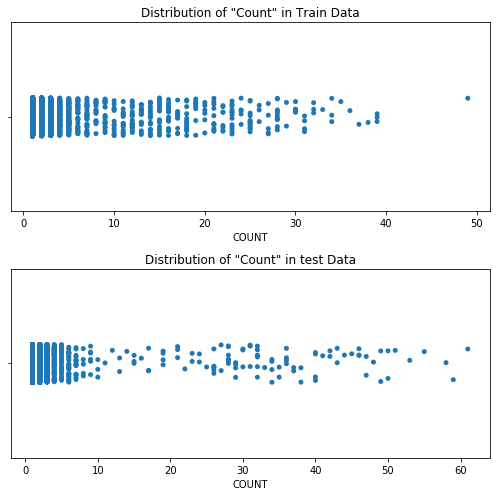

In [21]:
# sns.histplot(x='COUNT', data=data,hue='train/test', element="step");
f, axes=plt.subplots(2,1, figsize=(7,7))
sns.stripplot(x='COUNT', data=train, ax=axes[0])
axes[0].set_title('Distribution of "Count" in Train Data')

sns.stripplot(x='COUNT', data=test, ax=axes[1])
axes[1].set_title('Distribution of "Count" in test Data')
plt.tight_layout()
plt.show();

#test set의 10~20분포 << train set의 10~20분포 
#test set에는 30~61까지의 분포가 어느정도 있는 반면 train set에는 없음. 

In [22]:
print(f'train set - count=10~20 : {((train["COUNT"]>=10)& (train["COUNT"]<20)).sum()}')
print(f'test set  - count=10~20 : {((test["COUNT"]>=10)& (test["COUNT"]<20)).sum()}')
print('='*80)
print(f'train set - count>=30~40 : {((train["COUNT"]>=30)& (train["COUNT"]<40)).sum()}')
print(f'test set  - count>=30~40 : {((test["COUNT"]>=30)& (test["COUNT"]<40)).sum()}')
print('='*80)
print(f'train set - count>=40~50 : {((train["COUNT"]>=40)& (train["COUNT"]<50)).sum()}')
print(f'test set  - count>=40~50 : {((test["COUNT"]>=40)& (test["COUNT"]<50)).sum()}')
print('='*80)
print(f'train set - count>=50~70 : {((train["COUNT"]>=50)& (train["COUNT"]<70)).sum()}')
print(f'test set  - count>=50~70 : {((test["COUNT"]>=50)& (test["COUNT"]<70)).sum()}')

#40이상부터는 그냥 버려야하는 건가.. 

train set - count=10~20 : 153
test set  - count=10~20 : 19
train set - count>=30~40 : 22
test set  - count>=30~40 : 27
train set - count>=40~50 : 1
test set  - count>=40~50 : 19
train set - count>=50~70 : 0
test set  - count>=50~70 : 8


##### 월별

In [101]:
#월별 총 합계 
parking_1=data[data.Month==1]['COUNT'].groupby(data.Day).sum()
parking_2=data[data.Month==2]['COUNT'].groupby(data.Day).sum()
parking_3=data[data.Month==3]['COUNT'].groupby(data.Day).sum()
parking_4=data[data.Month==4]['COUNT'].groupby(data.Day).sum()
parking_5=data[data.Month==5]['COUNT'].groupby(data.Day).sum()
parking_6=data[data.Month==6]['COUNT'].groupby(data.Day).sum()
parking_7=data[data.Month==7]['COUNT'].groupby(data.Day).sum()
parking_8=data[data.Month==8]['COUNT'].groupby(data.Day).sum()
parking_9=data[data.Month==9]['COUNT'].groupby(data.Day).sum()

parking_10=data[data.Month==10]['COUNT'].groupby(data.Day).sum()
parking_11=data[data.Month==11]['COUNT'].groupby(data.Day).sum()
parking_12=data[data.Month==12]['COUNT'].groupby(data.Day).sum()

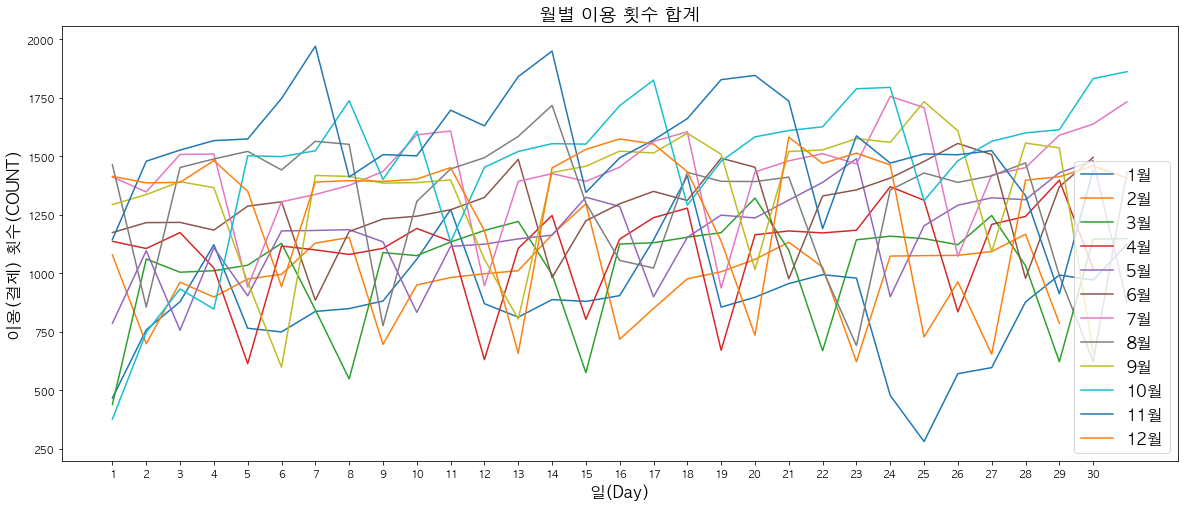

In [95]:
plt.figure(figsize=(20,8))
sns.lineplot(x=parking_1.index, y=parking_1.values)
sns.lineplot(x=parking_2.index, y=parking_2.values)
sns.lineplot(x=parking_3.index, y=parking_3.values)
sns.lineplot(x=parking_4.index, y=parking_4.values)
sns.lineplot(x=parking_5.index, y=parking_5.values)
sns.lineplot(x=parking_6.index, y=parking_6.values)
sns.lineplot(x=parking_7.index, y=parking_7.values)
sns.lineplot(x=parking_8.index, y=parking_8.values)
sns.lineplot(x=parking_9.index, y=parking_9.values)

sns.lineplot(x=parking_10.index, y=parking_10.values)
sns.lineplot(x=parking_11.index, y=parking_11.values)
sns.lineplot(x=parking_12.index, y=parking_12.values)

plt.xticks(np.arange(1, 31, step=1))
plt.legend(['1월', '2월', '3월', '4월','5월','6월','7월','8월','9월', '10월','11월','12월'], loc='best', fontsize=16)
plt.title('월별 이용 횟수 합계', fontsize=18)
plt.ylabel('이용(결제) 횟수(COUNT)', fontsize=16)
plt.xlabel('일(Day)', fontsize=16)
plt.show();

##### 분기별 

In [118]:
#월별로 보자니 복잡해서 분기별 혹은 계절별로 나눠보기로 함 

#분기 
data['quartile']=data['Month'].apply(lambda x : 1 if x<=3 else 2 if (x>3) & (x<=6) else 3 if (x>6) & (x<=9) else 4)

In [120]:
#분기별 
parking_1_4=data[data.quartile==1]['COUNT'].groupby(data.Day).sum()
parking_2_4=data[data.quartile==2]['COUNT'].groupby(data.Day).sum()
parking_3_4=data[data.quartile==3]['COUNT'].groupby(data.Day).sum()
parking_4_4=data[data.quartile==4]['COUNT'].groupby(data.Day).sum()

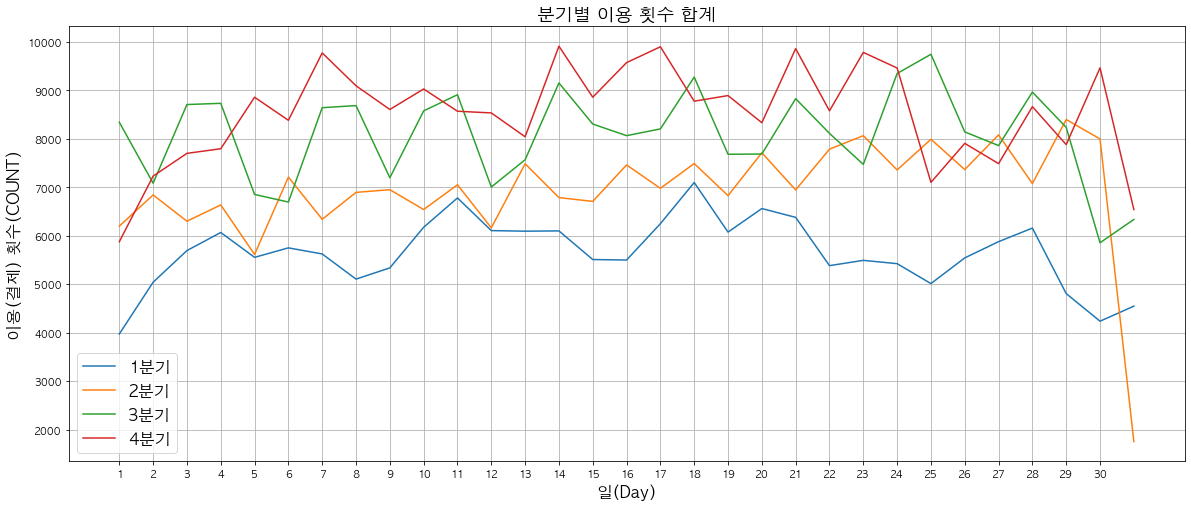

In [121]:
plt.figure(figsize=(20,8))
sns.lineplot(x=parking_1_4.index, y=parking_1_4.values)
sns.lineplot(x=parking_2_4.index, y=parking_2_4.values)
sns.lineplot(x=parking_3_4.index, y=parking_3_4.values)
sns.lineplot(x=parking_4_4.index, y=parking_4_4.values)

plt.grid()
plt.xticks(np.arange(1, 31, step=1))
plt.legend(['1분기', '2분기','3분기','4분기'], loc='best', fontsize=16)
plt.title('분기별 이용 횟수 합계', fontsize=18)
plt.ylabel('이용(결제) 횟수(COUNT)', fontsize=16)
plt.xlabel('일(Day)', fontsize=16)
plt.show();

# 1분기가 항상 낮고 3, 4분기가 엎치락 뒤치락함. 

In [217]:
# 딱히 seasonality, trend는 없음. cyclical 하기만 함. 
def plot_decompose(decomposerresult):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,8))
    decomposerresult.observed.plot(legend=False, ax=ax1)
    ax1.set_ylabel('Observed')
    decomposerresult.trend.plot(legend=False, ax=ax2)
    ax2.set_ylabel('Trend')
    decomposerresult.seasonal.plot(legend=False, ax=ax3)
    ax3.set_ylabel('Seasonal')
    decomposerresult.resid.plot(legend=False, ax=ax4)
    ax4.set_ylabel('Resid')

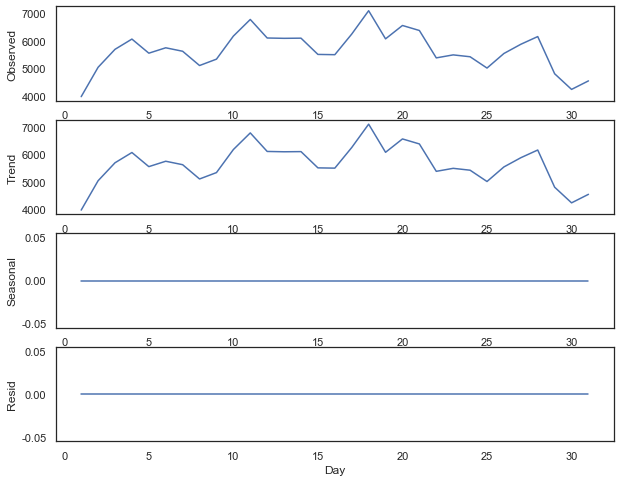

In [218]:
result = seasonal_decompose(parking_1_4, model = 'additive', period=1)
plot_decompose(result)

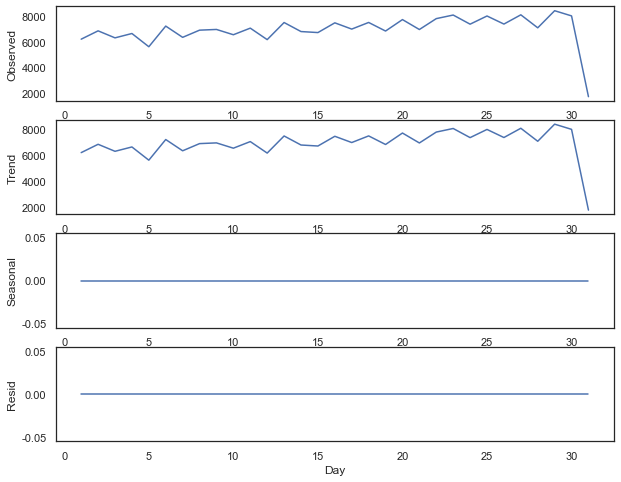

In [219]:
result = seasonal_decompose(parking_2_4, model = 'additive', period=1)
plot_decompose(result)

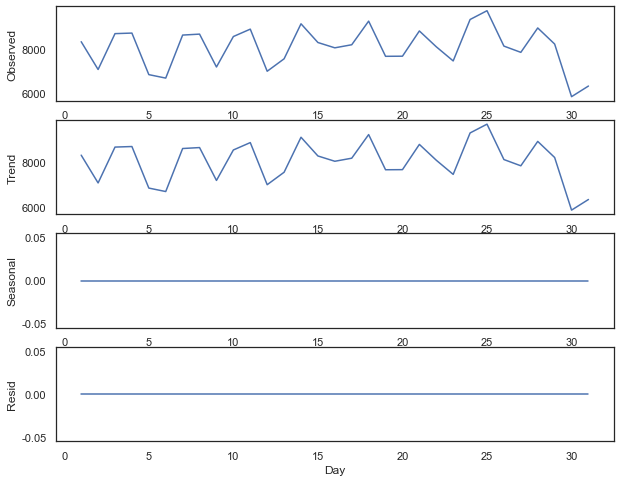

In [220]:
result = seasonal_decompose(parking_3_4, model = 'additive', period=1)
plot_decompose(result)

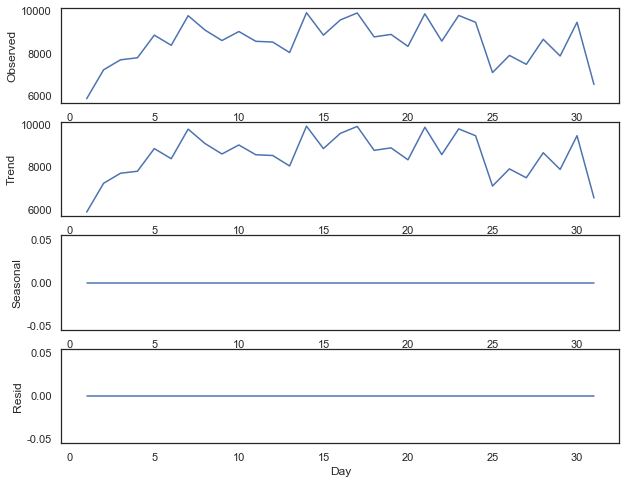

In [221]:
result = seasonal_decompose(parking_4_4, model = 'additive', period=1)
plot_decompose(result)

##### 요일별

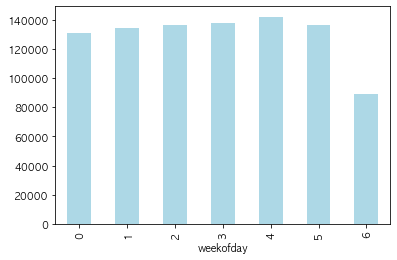

In [155]:
data.groupby('weekofday')['COUNT'].sum().plot(kind='bar', color='lightblue');
#0부터 순차적으로 월~일 
#대체로 비슷하고 일요일에 덜 함 

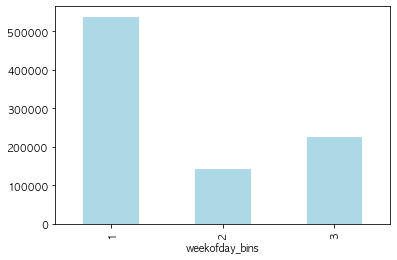

In [156]:
data['weekofday_bins']=data['weekofday'].apply(lambda x : 1 if x<=3 else 2 if x==4 else 3)
data.groupby('weekofday_bins')['COUNT'].sum().plot(kind='bar', color='lightblue');

# 1 : 월~목,  2: 금,  3: 토일 

##### GOODS_TYPE별 

In [170]:
data.columns

Index(['USER_ID', 'JOIN_DATE', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 'DATE',
       'COUNT', 'AD1', 'Month', 'Day', 'weekofday', 'train/test', 'quartile',
       'weekofday_bins'],
      dtype='object')

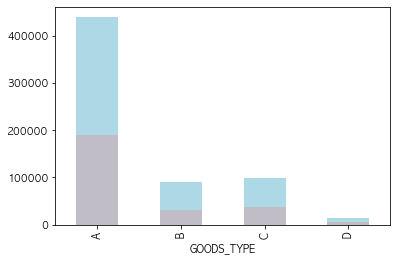

In [174]:
train.groupby('GOODS_TYPE')['COUNT'].sum().plot(kind='bar', color='lightblue');
test.groupby('GOODS_TYPE')['COUNT'].sum().plot(kind='bar', color='lightcoral', alpha=0.3);

##### D_TYPE별 

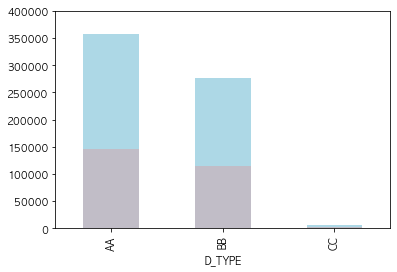

In [176]:
train.groupby('D_TYPE')['COUNT'].sum().plot(kind='bar', color='lightblue');
test.groupby('D_TYPE')['COUNT'].sum().plot(kind='bar', color='lightcoral', alpha=0.3, ylim=(0,400000));

In [203]:
data['JOIN_DAYS']=datetime(2020,12,31)-data['JOIN_DATE']
data['JOIN_DAYS']=data['JOIN_DAYS'].dt.days

In [ ]:
test['']

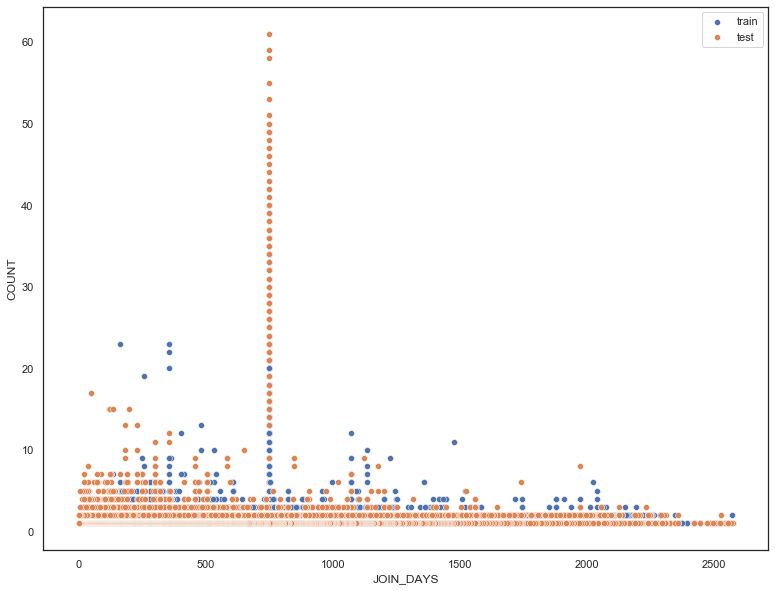

In [236]:
plt.figure(figsize=(13,10))
sns.scatterplot(x='JOIN_DAYS', y='COUNT', data=data[(data.DATE <'2020-09-01')&(data.JOIN_DAYS<5000)])   #outliers 제거하고 
sns.scatterplot(x='JOIN_DAYS', y='COUNT', data=data[(data.DATE >='2020-09-01')&(data.JOIN_DAYS<5000)])
plt.legend(['train', 'test'])
plt.show();

# train으로 잡히지 않는 test.. 

## Correlation

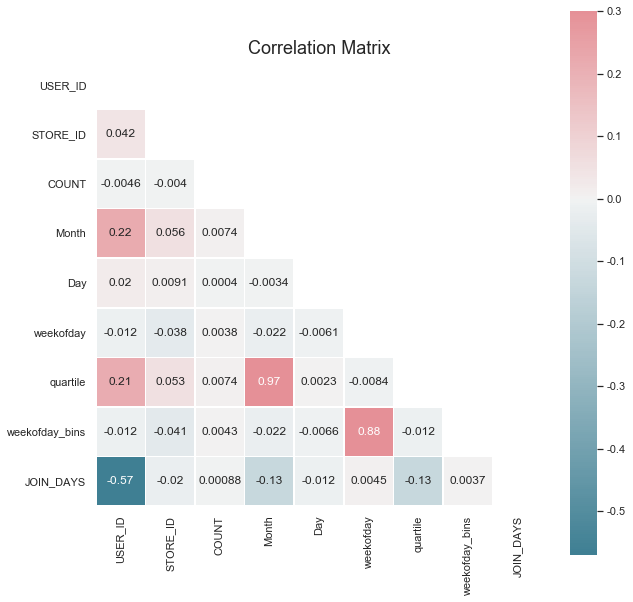

In [295]:
sns.set(style="white")
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()

In [291]:
drop_cols=['USER_ID', 'JOIN_DATE', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 'DATE',
        'AD1', 'Month', 'Day', 'weekofday', 'quartile',
       'weekofday_bins', 'JOIN_DAYS', 'point', 'weather_date']
temp_corr=data_all.drop(drop_cols,1).corr()

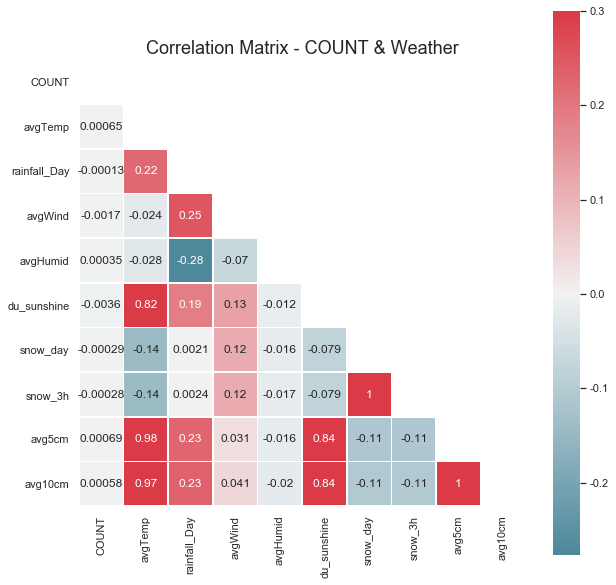

In [294]:
sns.set(style="white")
mask = np.triu(np.ones_like(temp_corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix - COUNT & Weather', fontsize=18)
sns.heatmap(temp_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()

## 1차 ISSUE 정리  
- train, test set의 COUNT간 특정 구간에 대한 분포차이가 있음. (train에는 없고 test에는 있는 구간) 이 구간에 속한 데이터들을 어떻게 해야할지 논의 필요  
- 거의 모든 COUNT가 1에 몰려있음 
- 시계열 데이터 특성을 사용한 분석이 필요한건지? 가능한건지? cyclical이 보이긴 한데 요것만 취해서 분석에 활용할 수 있는건지?  
- ID 컬럼 - 버리는 경우, 취하는 경우 모두 테스트 해 봐야할 듯?  
- D_TYPE, GOODS_TYPE, AD1 에 대한 정확한 정보 필요 
- 1차적으로는 COUNT 컬럼과 크게 상관있는 피처가 없어보임. Month제외하고. 그러니 외부 데이터를 활용해야 할 것 같은데 어떻게 활용할 건지? - 날씨 데이터 중 취할 피처, 교통량 정보는 어떻게 처리할건지  